## Library and checking Dir

In [ ]:
!pip uninstall transformers -y

Found existing installation: transformers 4.40.2
Uninstalling transformers-4.40.2:
  Successfully uninstalled transformers-4.40.2


In [ ]:
!pip3 install transformers==4.30

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

!pip3 install tensorflow==2.12.0
!pip3 install datasets
!pip3 install emoji==1.4.1
!pip3 install vncorenlp
!git clone https://github.com/vncorenlp/VnCoreNLP.git

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.16.22.226)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by SyncGlobal Telecom (Bremen, GA) [1261.06 km]: 35.398 ms
Testing download speed................................................................................
Download: 1911.60 Mbit/s
Testing upload speed......................................................................................................
Upload: 455.65 Mbit/s
fatal: destination path 'VnCoreNLP' already exists and is not an empty directory.


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import emoji
import regex as re
import functools
import operator
from vncorenlp import VnCoreNLP
from nltk import flatten
from tensorflow.python.client import device_lib

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.utils import plot_model
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import PhobertTokenizer
from transformers import TFAutoModel
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions
from datasets import load_dataset

## Check physical device and version Lib

In [ ]:
print("Version tf: " +  tf.__version__)
print("Devices: ")
print(device_lib.list_local_devices())

Version tf: 2.12.0
Devices: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10912829054581436818
xla_global_id: -1
]


In [ ]:
#TPU
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)

#CPU
#strategy = tf.distribute.get_strategy()

#GPU
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

## Google Colab Services

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#path_prc = ''
#os.chdir(path_prc)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Điều chỉnh tập dữ liệu

In [ ]:
train_path = "/content/drive/MyDrive/Train_Model_A01/train.csv"
test_path = "/content/drive/MyDrive/Train_Model_A01/test.csv"
val_path = "/content/drive/MyDrive/Train_Model_A01/val.csv"
train_dt = pd.read_csv(train_path)
val_dt = pd.read_csv(val_path)
test_dt = pd.read_csv(test_path)

In [ ]:
train_dt

,comment,label
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0
1,Xe_đẩy bán cơm_chiên nằm ngay đầu đường vào kh...,1
2,"Bingsu dưa lưới ăn chán lắm . Dưa lưới nhạt , ...",0
3,Mình tập_thể_dục xong qua làm một phần . 49k m...,1
4,"❤ ️ bánh_bao hông kong , bánh_bao xá_xíu , bán...",0
...,...,...
29995,Kem tuyết chocolate ngon khủng_khiếp ! Đúng ng...,1
29996,Kem ở đây cũng khá ngon . Nv nhiệt_tình mà ko ...,1
29997,"Kem tuyết được bào vào nửa trái dưa lưới , bên...",1
29998,"Nhìn trong hình tưởng bự , nhưng lúc mang ra c...",1


In [ ]:
test_dt

,comment,label
0,Quán này khá là nổi_tiếng nay mới có dịp ghé t...,0
1,Không hiểu sao các bạn khen được .... Mình đi ...,0
2,Quán quá tệ !. Mình ăn_ở đây được hai lần . Lầ...,0
3,"Vị_trí : quán ngay mặt_tiền , dễ tìm. Không_gi...",1
4,- Gà nướng không xương phô_mai ăn kèm khoai_tâ...,1
...,...,...
9995,Mì ở đây ngon hơn omega tuy không có cấp_độ nh...,1
9996,Đó giờ mới ăn 1 quán ngon đúng nghĩa . Tất_cả ...,1
9997,Quán này nhà mình ăn từ lâu lắm lăm luôn rồi m...,1
9998,Quán có nhiều món phù_hợp với nhiều đối_tượng ...,1


In [ ]:
val_dt

,comment,label
0,"Ko ngon . Khó kiếm địa_chỉ , dành cho mua mang...",0
1,"Vô cách đây 1 tuần mà giờ mới review , được an...",1
2,"Bữa có người bạn đãi sinh_nhật ở đây , 9ng ăn ...",1
3,"Ăn_ở quán được khoảng 4 5 lần gì đó , tính là ...",0
4,Chuyến đi tuyệt_vời cùng nhưng người địa_phươn...,1
...,...,...
9995,"Qua ́ n ăn na ̀ y thâ ̣ t tuyê ̣ t vơ ̀ i , mo...",1
9996,"Tiệm bánh plan khá nổi_tiếng ở Cần_Thơ , bánh ...",1
9997,"Ông_bà chủ siêu đáng iêu luôn . Phở gà , xôi g...",1
9998,"Ko gian quán khá rộng , mình kêu kem sầu_riêng...",1


In [ ]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  30000 non-null  object
 1   label    30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


In [ ]:
raw_dt = load_dataset('csv', data_files={'train': train_path, 'val': val_path, 'test': test_path})
raw_dt

DatasetDict({
    train: Dataset({
        features: ['comment', 'label'],
        num_rows: 30000
    })
    val: Dataset({
        features: ['comment', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['comment', 'label'],
        num_rows: 10000
    })
})

## Tiền xử lý dữ liệu

In [ ]:
#Điều chỉnh label
def verify_label(df):
    output = []
    for row in range(len(df)):
        vector_label = []
        label = df.iloc[row, 1]
        if label == 0:
            vec_label = [0]
        else:
            vec_label = [1]

        output.append(vec_label)
    return np.array(output, dtype='uint8')

In [ ]:
y_train = verify_label(train_dt)
y_val = verify_label(val_dt)
y_test = verify_label(test_dt)

In [ ]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [ ]:
y_val

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [ ]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [ ]:
# Xóa các ký tự liên quan đến html
def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)

# Chuẩn hóa dấu mũ, unicode
def to_unicode(text):
    char = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char = char.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char)):
        dic[char[i]] = charutf8[i]

    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )

# Giải mã viết tắt trong câu
replace_list = {
    'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'oke': 'ok', 'okay': 'ok',
    'tks': 'cảm ơn', 'thanks': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'k': 'không', 'kh': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không',
    'wa': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm',
    'ship': 'giao hàng', 'order': 'đặt hàng',
    'good': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'bt': 'bình thường', 'bthuong': 'bình thường',
    'sad': 'tệ',
    'thik': 'thích', 'fake': 'giả mạo',
    'dt': 'điện thoại', 'fb': 'facebook', 'nv': 'nhân viên',
    'ib': 'nhắn tin', 'tl': 'trả lời', 'reply': 'trả lời', 'rep': 'trả lời',
    'sd': 'sử dụng', 'sài': 'xài',
    'kb': 'không biết', 'cmt': 'đánh giá', 'ntn': 'như thế nào',
    '⭐': 'ngôi sao', '*': 'ngôi sao',

    '^_^': 'tích cực', '😁': 'tích cực', '🥰': 'tích cực', '👌':'tích cực',
    '❤️': 'tích cực', '👍': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực',
    '😔': 'tiêu cực', '🙂': 'tiêu cực', ':)': 'tiêu cực', ':(': 'tiêu cực', 'lol': 'tiêu cực', 'huhu': 'tiêu cực',
}

#with open('teencode.txt', encoding='utf-8') as f:
#    for pair in f.readlines():
#        key, value = pair.split('\t')
#        replace_list[key] = value.strip()

def split_emoji(text):
    emoji_split = emoji.get_emoji_regexp().split(text)
    emoji_split_space = [substr.split() for substr in emoji_split]
    emoji_spl = functools.reduce(operator.concat, emoji_split_space)
    return ' '.join(emoji_spl)

def normalize_text_emoji(text):
    words = []
    text = split_emoji(text)
    for word in text.strip().split():
        if word.lower() not in replace_list.keys():
            words.append(word)
        else:
            words.append(replace_list[word.lower()])

    return emoji.demojize(' '.join(words))

# Phân tích từ trong câu
annotator = VnCoreNLP('VnCoreNLP/VnCoreNLP-1.1.1.jar')
def word_segmen(text):
    words = annotator.tokenize(text)
    return ' '.join(word for word in flatten(words))

# Bo ky tu khong can thiet
def remove_char(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def text_preprocess(text):
    text = remove_html(text)
    text = to_unicode(text)
    text = normalize_text_emoji(text)
    text = word_segmen(text)
    text = remove_char(text)
    return text

## Test any Example

In [ ]:
seq = train_dt['comment'][2]
print(seq)

Bingsu dưa lưới ăn chán lắm . Dưa lưới nhạt , không có gì đáng để khen hết . Những món còn lại chưa thử nên không có ý_kiến !. 


In [ ]:
s = normalize_text_emoji(seq)
s

'Bingsu dưa lưới ăn chán lắm . Dưa lưới nhạt , không có gì đáng để khen hết . Những món còn lại chưa thử nên không có ý_kiến !.'

In [ ]:
s_segmen = word_segmen(s)
s_segmen

'Bingsu dưa lưới ăn chán lắm . Dưa lưới nhạt , không có gì đáng để khen hết . Những món còn lại chưa thử nên không có ý _ kiến ! .'

In [ ]:
remove_char(s_segmen)

'Bingsu dưa lưới ăn chán lắm Dưa lưới nhạt không có gì đáng để khen hết Những món còn lại chưa thử nên không có ý _ kiến'

## Processing input Model

In [ ]:
PRETRAINED_MODEL = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [ ]:
def tokenize_sentences(data):
    clean_sentences = list(map(text_preprocess, data['comment']))
    return tokenizer(clean_sentences, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

token_data = raw_dt.map(tokenize_sentences, batched = True)
token_data

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    val: Dataset({
        features: ['comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
print('Câu 2: ', token_data['train'][2]['comment'])
print('input_ids:', token_data['train'][2]['input_ids'])
print('attention_mask: ', token_data['train'][2]['attention_mask'])
print('token_type_ids:', token_data['train'][2]['token_type_ids'])

Câu 2:  Bingsu dưa lưới ăn chán lắm . Dưa lưới nhạt , không có gì đáng để khen hết . Những món còn lại chưa thử nên không có ý_kiến !. 
input_ids: [0, 924, 5936, 11645, 5332, 1865, 203, 5015, 957, 32498, 1865, 5634, 17, 10, 148, 463, 24, 2317, 351, 217, 526, 50, 44, 102, 1176, 77, 17, 10, 2198, 2926, 5603, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
attention_mask:  

In [ ]:
max_sentence_len = tokenizer.model_max_length
#cần điều chỉnh đường dẫn
model_path = '/content/drive/MyDrive/Train_Model_A01/Model'
batch_size = 15

steps_per_epoch = len(train_dt)/batch_size
validation_steps = len(val_dt)/batch_size
epochs = 20

In [ ]:
def to_tensorflow(token_data):
    features = token_data.features
    #https://huggingface.co/docs/datasets/use_with_tensorflow
    return token_data.remove_columns(list(features)[:-3]).with_format('tensorflow')

In [ ]:
# from tensorflow.data import Dataset
def preprocess_tokenized_dataset(token_data, tokenizer, labels, batch_size, shuffle=False):
    tf_dt = to_tensorflow(token_data)
    features = {x: tf_dt[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    #https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    tf_dt = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dt = tf_dt.shuffle(buffer_size=len(tf_dt))
    return tf_dt.batch(batch_size)

In [ ]:
train_tf = preprocess_tokenized_dataset(token_data['train'], tokenizer, y_train, batch_size, shuffle=True)
val_tf = preprocess_tokenized_dataset(token_data['val'], tokenizer, y_val, batch_size)
test_tf = preprocess_tokenized_dataset(token_data['test'],  tokenizer, y_test, batch_size)

In [ ]:
train_tf

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

## Xây dựng mô hình

In [ ]:
def create_model(optimizer):
    # https://riccardo-cantini.netlify.app/post/bert_text_classification
    inputs = {
        'input_ids'     : Input((max_sentence_len,), dtype='int32', name='input_ids'),
        'token_type_ids': Input((max_sentence_len,), dtype='int32', name='token_type_ids'),
        'attention_mask': Input((max_sentence_len,), dtype='int32', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    # https://github.com/huggingface/transformers/issues/1328
    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]),
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    # print(pooled_output)

    #https://keras.io/api/layers/core_layers/dense/
    outputs = concatenate([
        Dense(
            units = 4,
            activation = 'softmax',
            name = label.replace('&', '-'),
        )(x) for label in train_dt.columns[1:]
    ], axis = -1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

In [ ]:
optimizer = Adam(learning_rate=1e-5)
type(optimizer)

keras.optimizers.adam.Adam

In [ ]:
# Create the EarlyStopping callback.
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Create the checkpoint path.
checkpoint_path = model_path + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create the CheckpointOptions object.
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create the ModelCheckpoint callback.
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    save_weights_only=True,
    save_freq=10 * int(steps_per_epoch),
    verbose=1
)

In [ ]:
with strategy.scope():
    model = create_model(optimizer)
    #https://keras.io/api/models/model_training_apis/
    history = model.fit(
        train_tf,
        epochs = epochs,
        verbose = 1,
        callbacks = [
            early_stop_callback,
            checkpoint_callback
        ],
        validation_data = val_tf,
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
    )
    model.save_weights(f'{model_path}/weights.h5')

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


2000/2000 [==============================] - 289s 100ms/step - loss: 0.8403 - val_loss: 0.8370
Epoch 2/20
2000/2000 [==============================] - 187s 94ms/step - loss: 0.8379 - val_loss: 0.8370
Epoch 3/20
2000/2000 [==============================] - 187s 93ms/step - loss: 0.8374 - val_loss: 0.8370
Epoch 4/20
2000/2000 [==============================] - 191s 96ms/step - loss: 0.8373 - val_loss: 0.8371
Epoch 5/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8372 - val_loss: 0.8370
Epoch 6/20
2000/2000 [==============================] - 187s 93ms/step - loss: 0.8371 - val_loss: 0.8370
Epoch 7/20
2000/2000 [==============================] - 187s 93ms/step - loss: 0.8371 - val_loss: 0.8370
Epoch 8/20
2000/2000 [==============================] - 187s 93ms/step - loss: 0.8371 - val_loss: 0.8370
Epoch 9/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8371 - val_loss: 0.8370
Epoch 10/20
1999/2000 [============================>.] - ETA: 0s 

2000/2000 [==============================] - 186s 93ms/step - loss: 0.8371 - val_loss: 0.8370
Epoch 11/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8371 - val_loss: 0.8370
Epoch 12/20
2000/2000 [==============================] - 187s 93ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 13/20
2000/2000 [==============================] - 187s 94ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 14/20
2000/2000 [==============================] - 187s 94ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 15/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 16/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 17/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 18/20
2000/2000 [==============================] - 186s 93ms/step - loss: 0.8370 - val_loss: 0.8370
Epoch 19/20
2000/2000 [==============================] - 1

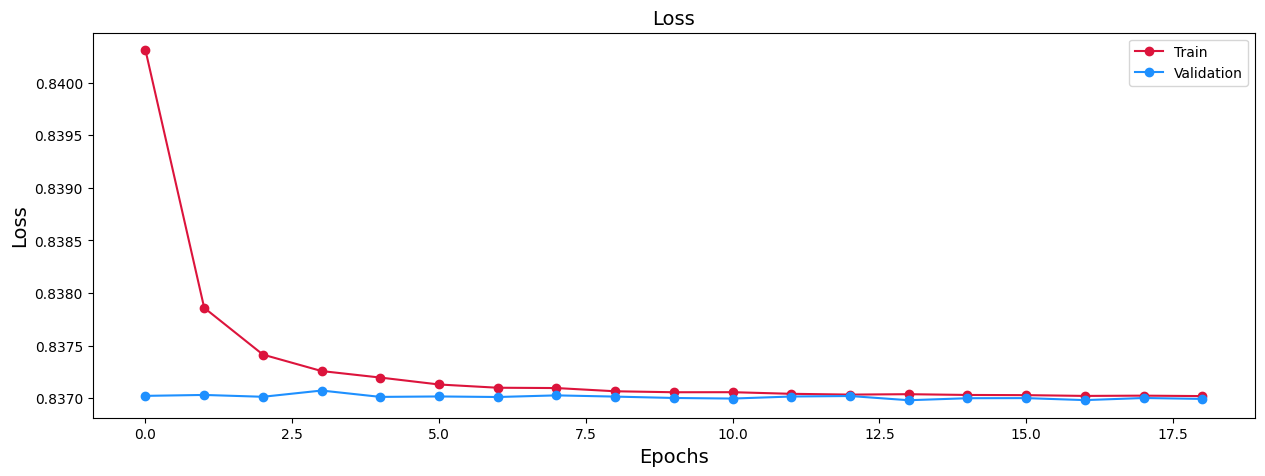

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=14)
plt.legend(loc='best')
fig.savefig(f'{model_path}/evaluation.png', bbox_inches='tight')
plt.show()

In [ ]:
# from tensorflow.train import latest_checkpoint
with strategy.scope():
    reloaded_model = create_model(optimizer)
    reloaded_model.load_weights(f'{model_path}/weights.h5')
    reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134998272  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]',        

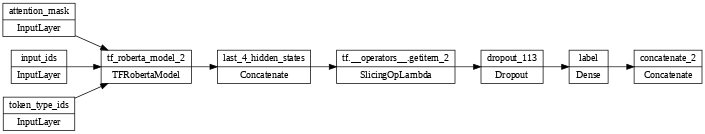

In [ ]:
plot_model(reloaded_model, to_file=f'{model_path}/architecture.png', rankdir='LR', dpi=52)

In [53]:
y_test_argmax = np.argmax(y_test, axis=-1)
for i in y_test_argmax:
  print(i)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [54]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1)

In [55]:
def print_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category} : {sentiment}')

In [56]:
with strategy.scope():
    y_pred = predict(reloaded_model, test_tf, batch_size, verbose=1)
    reloaded_model.evaluate(test_tf, batch_size=batch_size, verbose=1)

667/667 [==============================] - 34s 28ms/step - loss: 0.8370


In [57]:
test_number_id = 0
replacements = {0: 'Tiêu cực', 1: 'Tích cực'}
categories = test_dt.columns[0:]
print('Mẫu thử:', test_dt['comment'][test_number_id])
print_pred(replacements, categories, y_pred[test_number_id])

Mẫu thử: Quán này khá là nổi_tiếng nay mới có dịp ghé thử . Năm ở vii trí khá dễ tìm , quán hơi nhỏ , đi chiều_tối là đông lắm phải đợi lâu. Nhân_viên thì bình_thường à vì do đông quá nên cũng thông_cảm. Món ăn :. Mình gọi gà sốt phô_mai cay : gà quá bở , thịt ăn vào k thơm , món này đã có mỡ rồi cộng thêm da_gà nữa ăn rất ngáy . Cảm_giác ngán lắm. Cơm trộn kim_chi HQ thì_phải : ăn hơi cay , nóng_hổi luôn , vị ăn ok nhưng k đặc_sắc . Với giá đó thì ăn k đáng tiền .. Khoai_tây chiên : dở và ăn vị k ngon. Tóm_lại k như kì_vọng của mình , giá_cả ở đây quá đắt so với chất_lượng . Mà đi ăn phải chầu_chực như_thế thì cũng hơi mệt. À có nước_lọc miễn_phí nha . Mọi người tới ăn nhớ hỏi .. 
=> comment : Tích cực


In [58]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    Tiêu cực     1.0000    0.0002    0.0004     10000
    Tích cực     0.0000    0.0000    0.0000         0

    accuracy                         0.0002     10000
   macro avg     0.5000    0.0001    0.0002     10000
weighted avg     1.0000    0.0002    0.0004     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
